# Monte Carlo Simulation: Stock Price Forecast

In this notebook, I will forecast the price of Intel Corporation over 60 days. I will use a Monte Carlo simulation to generate different random walk predictions of Intel's price. The historical data will be divided in two sets; the first one will be the training data and will contain approximate 10 years of daily prices. The second set will be a test sample of the last 60-day prices of the stock; then, I will compare the results of the Monte Carlo simulation and te test dataset to evaluate accuarcy and draw conclusions. 

Let's start by importing all the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


I will also define helpful variables that will use later to scrap and plot the relevant data. 

In [2]:
stock = 'INTC' #Stock ticker symbol
start = '2010-1-1' #Start of the period for the analysis

#Dictionaries to customize the font of labels and titles
label_dict = {'fontsize': 14,
            'fontweight' : 5,
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'
             }
title_dict = {'fontsize': 20,
           'fontweight' : 5,
           'verticalalignment': 'baseline',
           'horizontalalignment': 'center'
             }


Now, I will import the data from yahoo finance using the <code>pandas_datareader</code> library to import the price data. In this case, I will use the Adjusted Close price because this takes into account changes due to stock splits, reverse splits and dividends.

In [3]:
data = pd.DataFrame()
data[stock] = wb.DataReader(stock, data_source = 'yahoo', start = start)['Adj Close']
    
data.head()

,INTC
Date,
2010-01-04,15.063472
2010-01-05,15.056260
2010-01-06,15.005755
2010-01-07,14.861475
2010-01-08,15.027405
...,...
2020-10-20,53.430000
2020-10-21,53.500000
2020-10-22,53.900002


Let's take a look to the relevant information of the data set. As noted below, there are 2,723 observations; all of these ones are float type and there are no null values; thus, we don't need to perform any transformation or adjustment to our data set.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2723 entries, 2010-01-04 to 2020-10-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INTC    2723 non-null   float64
dtypes: float64(1)
memory usage: 42.5 KB


Let's plot the historical price in a line chart. The stock has an upward long-term trend that started by beginning 2013. However, we can see the impact of Covid crash at the beginning of 2020 followed by a notable recovery that lasted few months. By July 2020, the stock fell considerable again after the company dropped its revenue forecasts for Q3-2020 and announced delays on new products. 

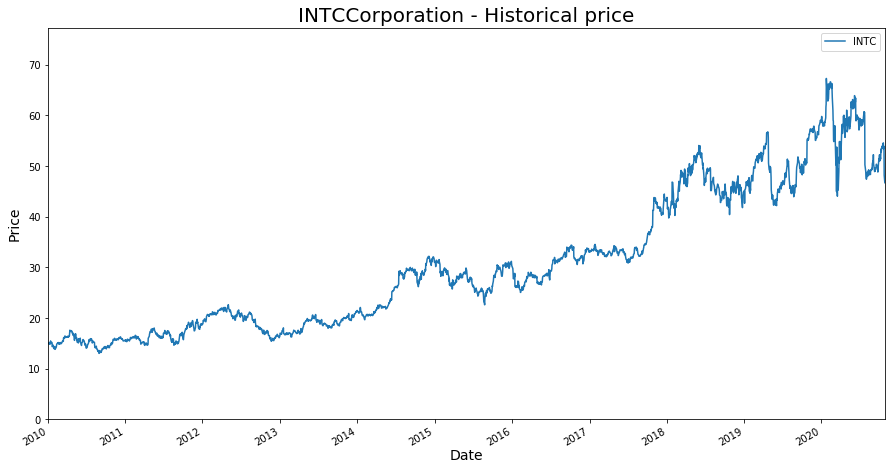

In [5]:
data.plot(xlim=(start,data.index.max()),ylim=(0,data.values.max()+10),figsize=(15,8))

plt.title(stock + ' Corporation - Historical price', fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Date', labelpad = 12, fontdict = label_dict)

plt.show()

The next step will be to divide our data set into two samples. I will call <code>data_train</code> to the training set that will help to fit the model to make the forecast, and the <code>data_test</code> will be used as a control to evaluate the accuracy of the prediction.

In [6]:
data_train = data.iloc[:-60]
data_test = data.iloc[-60:]

Now, let's calculate the daily returns of the stock. I will use the natural logarithm of the returns because the trend of the stock is an exponential growth rather than just linear. The method <code>pct_change</code> will be helpful to calculate the percentual change in the data series. 

In [7]:
Returns = np.log(data_train.pct_change()+1)
Returns.head()

,INTC
Date,
2010-01-04,NaN
2010-01-05,-0.000479
2010-01-06,-0.003360
2010-01-07,-0.009662
2010-01-08,0.011103
...,...
2020-07-27,-0.020368
2020-07-28,-0.006679
2020-07-29,-0.024048


Taking a look to the graph of the returns, we could see that the mean over the period is relatively stable and constant. In the same manner, the volatility of the stock fluctuates in an specific range although there are some spikes these are outliers. Based on this analysis, we can conclude that the returns of the stock follow a normal distribution with an stable mean.  

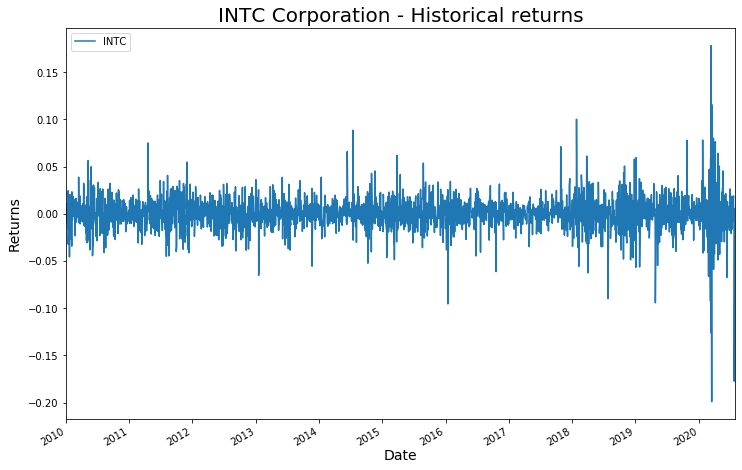

In [8]:
Returns.plot(xlim=(start,Returns.index.max()), figsize=(12,8))

plt.title(stock + ' Corporation - Historical returns', fontdict= title_dict)
plt.ylabel('Returns', labelpad = 10, fontdict = label_dict)
plt.xlabel('Date', labelpad = 12, fontdict = label_dict)

plt.show()

# Brownian movement

\begin{equation*}
\large{Price\ today = Price\ yesterday *  e ^ {\mu - \frac{1}{2}\sigma^2 + \sigma * Z(Rand(0;1))}}
\end{equation*} 

In [9]:
Mu = Returns.mean()
Mu

INTC    0.000431
dtype: float64

In [10]:
var = Returns.var()
var

INTC    0.00032
dtype: float64

In [11]:
std = Returns.std()
std

INTC    0.017875
dtype: float64

\begin{equation*}
\large{Drift = \mu - \frac{1}{2}\sigma^2}
\end{equation*} 

In [12]:
drift = Mu - 1/2*var
drift

INTC    0.000271
dtype: float64

In [13]:
t_interval = 60
iterations_1 = 50

In [14]:
daily_returns = np.exp(np.array(drift) + 
                       np.array(std) * norm.ppf(np.random.rand(t_interval,iterations_1)))
daily_returns

array([[0.99753604, 1.02815804, 1.02890044, ..., 0.9928958 , 1.0258347 ,
        0.98522298],
       [0.99419743, 0.97768941, 0.97919412, ..., 0.98434837, 0.99920128,
        1.015163  ],
       [1.00207219, 0.9821633 , 1.03202552, ..., 1.00430524, 0.9880185 ,
        1.02790947],
       ...,
       [1.00603399, 0.9503113 , 1.02252567, ..., 1.04301755, 1.0237106 ,
        1.01335253],
       [0.98425457, 0.97995717, 1.03916591, ..., 0.99105829, 0.97625419,
        1.04997933],
       [0.98760507, 0.98991894, 0.98281094, ..., 0.98944642, 0.99401952,
        0.99278518]])

In [15]:
daily_returns.shape

(60, 50)

In [16]:
S0 = data.iloc[-1]
S0

INTC    46.720001
Name: 2020-10-26 00:00:00, dtype: float64

In [17]:
price_list = np.zeros_like(daily_returns)
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
price_list[0] = S0
price_list

array([[46.72000122, 46.72000122, 46.72000122, ..., 46.72000122,
        46.72000122, 46.72000122],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [19]:
for t in range(1,t_interval):
    price_list[t] = price_list[t-1] * daily_returns[t]

price_list

array([[46.72000122, 46.72000122, 46.72000122, ..., 46.72000122,
        46.72000122, 46.72000122],
       [46.44890529, 45.6776505 , 45.74795055, ..., 45.98875683,
        46.68268524, 47.42841671],
       [46.54515622, 44.86291177, 47.2130526 , ..., 46.18674957,
        46.12335648, 48.75211889],
       ...,
       [51.50012648, 51.25997582, 39.34595277, ..., 46.74764589,
        40.94248036, 53.04333794],
       [50.68923503, 50.2325809 , 40.88697273, ..., 46.32964199,
        39.97026815, 55.6944085 ],
       [50.06094526, 49.7261833 , 40.18416413, ..., 45.84069851,
        39.73122668, 55.2925836 ]])

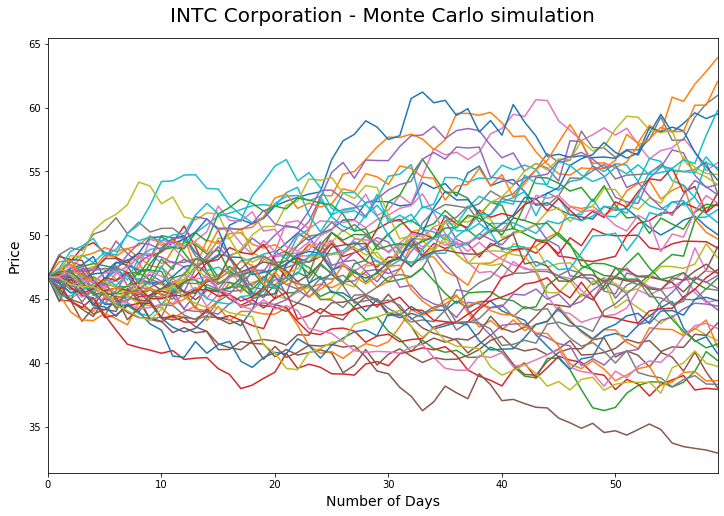

In [20]:
plt.figure(figsize=(12,8))
plt.plot(price_list)

plt.xlim(left = 0,right = t_interval-1)
plt.title(stock  + ' Corporation - Monte Carlo simulation',pad = 16, fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Number of Days', labelpad = 16, fontdict = label_dict)

plt.show()

In [21]:
price_list.max()

63.9186570220068

In [22]:
df = pd.DataFrame(price_list)
df1 = pd.concat([pd.DataFrame(df[i].values, columns=[stock]) for i in range(len(df.columns.values))],ignore_index=True)
df1.describe()

,INTC
count,3000.000000
mean,47.594137
std,4.735812
min,32.935997
25%,44.678834
50%,47.073072
75%,50.488595
max,63.918657


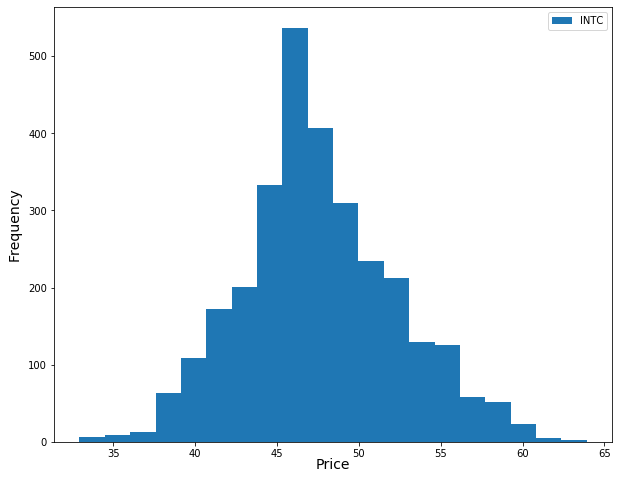

In [26]:
df1.plot.hist(figsize=(10,8),bins=20)
plt.xlabel('Price',labelpad = 10,fontdict = label_dict)
plt.ylabel('Frequency',labelpad = 10,fontdict = label_dict)
plt.show()

In [27]:
pred_price = []

for i in range(1,t_interval):
    pred_price.append(price_list[i].mean())


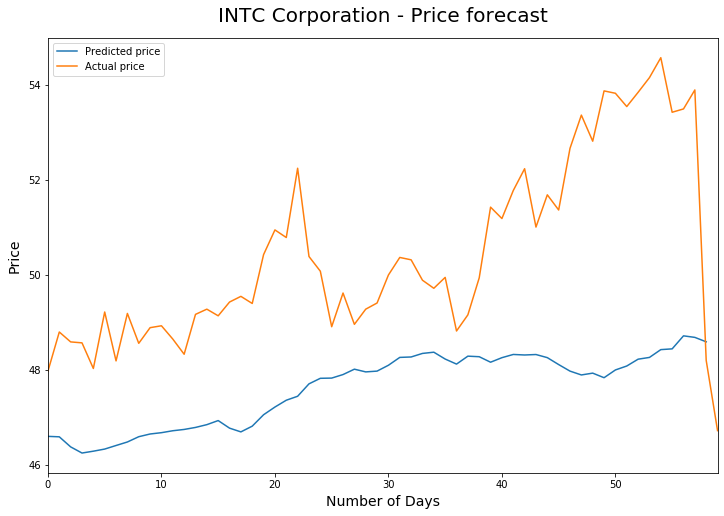

In [31]:
plt.figure(figsize=(12,8))
plt.plot(pred_price,label='Predicted price')
plt.plot(data_test.values,label='Actual price')

plt.xlim(left = 0,right = t_interval-1)
plt.title(stock + ' Corporation - Price forecast',pad = 16, fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Number of Days', labelpad = 16, fontdict =label_dict)

plt.legend()
plt.show()

_References:_

- https://www.cnbc.com/2020/07/23/intel-intc-earnings-q2-2020.html

